<a href="https://colab.research.google.com/github/Jake-BS/dissertation_code/blob/main/Dissertation_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Config options**

`backupDir` Set to a folder in your gdrive so that trained weights are saved even if the runtime times out.

`resume` Continue training based on any existing weights files in `backupDir`.

`color` Disable hue augmentation if you want the network to use colour as part of the classification decisions.

`tiny` Use the tiny version of yolo. Faster to train and run but less accurate.

`yolo` Set yolo version to use, 3 or 4 supported at present.

In [1]:
resume = False             # resume training that was previously stopped
color = True              # use color for classification
tiny = True               # train tiny yolo model
yolo = 4                 # yolo version to use
trainProp = 0.6           # proportion of images to use for training - changed from 6 to 8
testProp = 0.2
multiplier = 1            # training multiplier, train beyond 'recommeneded'
colabFree = False         # if using a free version of colab this might be required

datasetFile = "/content/gdrive/MyDrive/Dissertation/08_Jake_done.tar.xz"
backupDir = "/content/gdrive/MyDrive/Dissertation/backup"
classesFile = "/content/gdrive/MyDrive/Dissertation/classes.txt"

# You probably don't need to touch anything below this line
rebuild = False           # recompile darknet, set to true if you have changed any of the options below
size = None, None         # change network input size, set as None, None to use the default

#if yolo == 4: size = 416, 416
size = 416, 416

# try it out
#size = 416, 736

# input size must be multiple of 32
assert( size[0]%32 == 0 )
assert( size[1]%32 == 0 )

validProp = 1 - trainProp - testProp

gpu_info = !nvidia-smi   # automatically detect if you are using a gpu runtime
gpu = '\n'.join(gpu_info).find('failed') == -1

tensor = True
opencv = True
cudnn = True

import os

wrkDir = "/content"

tempDir = os.path.join( wrkDir, "temp" )
dataDir = os.path.join( wrkDir, "data" )
yoloDir = os.path.join( wrkDir, "yolo" )
#What should this file be?
darknetDir = os.path.join( wrkDir, "darknet" )
trainingDir = os.path.join(yoloDir, "training")

dataFile = os.path.join(yoloDir, "obj.data")
namesFile = os.path.join(yoloDir, "obj.names")
trainingFile = os.path.join(yoloDir, "train.txt")
testingFile = os.path.join(yoloDir, "test.txt")
validFile = os.path.join(yoloDir, "valid.txt")
trainingCfgFile = os.path.join(yoloDir, "training.cfg")
trainedCfgFile = os.path.join(yoloDir, "trained.cfg")
weightsFile = os.path.join(yoloDir,"yolo.weights")
trainedWeightsFile = os.path.join( backupDir, "training_best.weights" )


In [2]:
# display config options
print( f"colabFree  = {colabFree}" )
print( f"color      = {color}" )
print( f"cudnn      = {cudnn}" )
print( f"gpu        = {gpu}" )
print( f"multiplier = {multiplier}" )
print( f"opencv     = {opencv}" )
print( f"rebuild    = {rebuild}" )
print( f"resume     = {resume}" )
print( f"size       = {size}" )
print( f"tensor     = {tensor}" )
print( f"testProp   = {testProp}" )
print( f"tiny       = {tiny}" )
print( f"trainProp  = {trainProp}" )
print( f"validProp  = {validProp}" )
print( f"yolo       = {yolo}" )
print()

print( f"tempDir     = {tempDir}" )
print( f"dataDir     = {dataDir}" )
print( f"yoloDir     = {yoloDir}" )
print( f"darknetDir  = {darknetDir}" )
print( f"trainingDir = {trainingDir}" )
print( f"backupDir   = {backupDir}" )
print()

print( f"dataFile           = {dataFile}" )
print( f"namesFile          = {namesFile}" )
print( f"trainingFile       = {trainingFile}" )
print( f"testingFile        = {testingFile}" )
print( f"trainingCfgFile    = {trainingCfgFile}" )
print( f"trainedCfgFile     = {trainedCfgFile}" )
print( f"trainedWeightsFile = {trainedWeightsFile}" )
print( f"validFile          = {validFile}" )
print( f"weightsFile        = {weightsFile}" )

colabFree  = False
color      = True
cudnn      = True
gpu        = True
multiplier = 1
opencv     = True
rebuild    = False
resume     = False
size       = (416, 416)
tensor     = True
testProp   = 0.2
tiny       = True
trainProp  = 0.6
validProp  = 0.2
yolo       = 4

tempDir     = /content/temp
dataDir     = /content/data
yoloDir     = /content/yolo
darknetDir  = /content/darknet
trainingDir = /content/yolo/training
backupDir   = /content/gdrive/MyDrive/Dissertation/backup

dataFile           = /content/yolo/obj.data
namesFile          = /content/yolo/obj.names
trainingFile       = /content/yolo/train.txt
testingFile        = /content/yolo/test.txt
trainingCfgFile    = /content/yolo/training.cfg
trainedCfgFile     = /content/yolo/trained.cfg
trainedWeightsFile = /content/gdrive/MyDrive/Dissertation/backup/training_best.weights
validFile          = /content/yolo/valid.txt
weightsFile        = /content/yolo/yolo.weights


# Mount your google drive, and extract the contents of your dataset .zip

In [3]:
        #mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
#!ln -s "/content/gdrive/My Drive/" /mydrive

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!rm -r {tempDir}
!mkdir -p {tempDir}
#!unzip -qo {datasetFile} -d {tempDir}
!tar -xf {datasetFile} --directory {tempDir}
!ls {tempDir}

08_Jake_done


## Move all image and text files from the extract directory into the data directory.

So we don't have to deal with different directory structures going forwards

In [5]:
import glob, os, shutil

try: shutil.rmtree( dataDir )
except FileNotFoundError: pass

os.makedirs( dataDir )

# find and relocate all images
print( f"Move contents of {tempDir}")

for ext in ('*.png', '*.jpg', "*.txt"):
  globPath = os.path.join( tempDir, "**", ext )
  print( globPath )
  for filename in glob.glob( globPath, recursive=True ):
    print( filename )
    shutil.copyfile( filename, os.path.join( dataDir, os.path.split(filename)[-1] ) )

Move contents of /content/temp
/content/temp/**/*.png
/content/temp/**/*.jpg
/content/temp/08_Jake_done/vid_108_frame_491.jpg
/content/temp/08_Jake_done/vid_108_frame_532.jpg
/content/temp/08_Jake_done/vid_108_frame_739.jpg
/content/temp/08_Jake_done/vid_108_frame_644.jpg
/content/temp/08_Jake_done/vid_108_frame_212.jpg
/content/temp/08_Jake_done/vid_109_frame_211.jpg
/content/temp/08_Jake_done/vid_109_frame_285.jpg
/content/temp/08_Jake_done/vid_108_frame_88.jpg
/content/temp/08_Jake_done/vid_108_frame_281.jpg
/content/temp/08_Jake_done/vid_109_frame_183.jpg
/content/temp/08_Jake_done/vid_108_frame_646.jpg
/content/temp/08_Jake_done/vid_108_frame_637.jpg
/content/temp/08_Jake_done/vid_109_frame_225.jpg
/content/temp/08_Jake_done/vid_108_frame_201.jpg
/content/temp/08_Jake_done/vid_108_frame_402.jpg
/content/temp/08_Jake_done/vid_108_frame_368.jpg
/content/temp/08_Jake_done/vid_108_frame_662.jpg
/content/temp/08_Jake_done/vid_108_frame_528.jpg
/content/temp/08_Jake_done/vid_109_frame_1

## Check dataset is valid

- Classes file is present and readable.
- Images are jpgs (convert if needed).
- Images have matching labels.
- Label files are correctly formatted.

In [6]:
# name your classes
#classes = ["blue","orange","yellow"]
with open( os.path.join(dataDir, classesFile), "r" ) as f:
  classes = [ i.strip() for i in f ]

print( classes )

['blue', 'orange', 'yellow']


In [7]:
#convert pngs to jpg
#!apt install -y imagemagick

import os, glob, re
import cv2

# convert pngs
for filename in glob.glob( f"{dataDir}/*.png" ):
  print( f"Convert {filename}" )
  #os.system( f'convert "{filename}" "{filename.replace(".png",".jpg")}"' )
  #os.remove( filename )
  image = cv2.imread( filename )
  if image is None:
    print( f"Failed to open {filename}" )
  else:
    cv2.imwrite( ".".join(filename.split(".")[:-1])+".jpg", image )
  os.remove( filename )

# check label file exists
for filename in glob.glob( f"{dataDir}/*.jpg" ):
  if not os.path.exists( filename.replace( ".jpg", ".txt" ) ):
    print( f"Missing labels {filename}" )
    os.remove( filename )

# confirm images are valid
#for filename in glob.glob( f"{dataDir}/*.jpg" ):
#  result = os.system( f"identify -format '%f' '{filename}'" )
#  if result:
#      print( f"Identify fail {filename}" )
      #os.remove( filename )

# confirm that label files are in correct format
yoloReg = re.compile( r"^(\s*([0-9]{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s{1,}(\S{1,})\s*|\s*)$" )
for filename in glob.glob( f"{dataDir}/*.txt" ):
  if filename.endswith( classesFile ): continue

  valid = True
  with open( filename, "r" ) as f:
    for line in f:
      matches = yoloReg.match( line ).groups()
      
      c = int(matches[1])
      if c<0 or c>=len(classes): valid = False
      else:
        for i in matches[-4:]:
          i = float(i)
          if i<0 or i>1: valid = False

  if not valid:
    print( f"{filename} is invalid" )
    os.remove( filename )
    os.remove( filename.replace(".txt", ".jpg") )


# **Clone `darknet` git repository** 

Needed now as we are about to start generating the configuration files based on the default ones


In [8]:
if not os.path.exists( darknetDir ) or rebuild:
  try: shutil.rmtree( darknetDir )
  except FileNotFoundError: pass

  !git clone https://github.com/AlexeyAB/darknet {darknetDir}

  #os.system( f"git clone https://github.com/AlexeyAB/darknet {darknetDir}" )

  #!git clone https://github.com/leggedrobotics/darknet /content/darknet
  #!git clone https://github.com/pjreddie/darknet {darknetDir}

## Create config files


In [9]:
try: shutil.rmtree( yoloDir )
except FileNotFoundError: pass

os.makedirs( yoloDir )

print( f"Create {dataFile}" )
with open( dataFile, "w" ) as f:
  f.write( f"classes = {len(classes)}\n" )
  f.write( f"train = {trainingFile}\n" )
  f.write( f"test = {testingFile}\n" )
  f.write( f"valid = {validFile}\n" )
  f.write( f"names = {namesFile}\n" )
  f.write( f"backup = {backupDir}\n" )
!cat {dataFile}

print( f"Create {namesFile}" )
with open( namesFile, "w" ) as f:
  for i in classes:
    f.write( f"{i}\n" )

Create /content/yolo/obj.data
classes = 3
train = /content/yolo/train.txt
test = /content/yolo/test.txt
valid = /content/yolo/valid.txt
names = /content/yolo/obj.names
backup = /content/gdrive/MyDrive/Dissertation/backup
Create /content/yolo/obj.names


In [10]:
# split the images into testing and training groups
# assuming that similar images have similar files names, this approach ensures
# a representative distribution between the groups and will produce the same
# split every time

import math, os

files = sorted( [ i for i in os.listdir( dataDir ) if i.endswith(".jpg") ] )

buckets = ( [ open( trainingFile, "w" ), 0, trainProp ],
			      [ open( testingFile, "w" ), 0, testProp ], 
			      [ open( validFile, "w" ), 0, validProp ] )

for img in files:
  s = sorted( buckets, key=lambda i: i[1] / (len(files)*i[2]) if i[2] else math.inf )

  s[0][1] += 1
  s[0][0].write( f"{os.path.join(dataDir,img)}\n" )

for f, count, _ in buckets:
  print( count )
  f.close()


60
20
20


## **Generate network config files**


In [11]:


def setParameters(width, height, angle, saturation, hue, blur, momentum, decay, learning, os):
  import os, re

  # how many training images have we got
  try:
    with open(trainingFile, 'r') as f:
      images = sum( ( 1 for i in f if i.strip() != "" ) )
  except:
    images = 1000

  #The below switch statement can be used to chose which test config file to run
  sourceFiles = { (3,True):  os.path.join( darknetDir, "cfg", "yolov3-tiny.cfg" ),
                  (3,False): os.path.join( darknetDir, "cfg", "yolov3.cfg" ),
                  (4,True):  os.path.join( darknetDir, "cfg", "yolov4-tiny-custom.cfg" ),
                  (4,False): os.path.join( darknetDir, "cfg", "yolov4-custom.cfg" )}
 
  #maxBatches = max(len(classes)*2000,images,6000) * multiplier
  maxBatches = 50
  steps = int(maxBatches*0.8), int(maxBatches*0.9)
  replacements = [ 
    ( r"^\s*batch\s*=\s*[0-9]{1,}",        f"batch={[64,32][colabFree]}\n" ),
    ( r"^\s*subdivisions\s*=\s*[0-9]{1,}", f"subdivisions={[16,8][colabFree]}\n" ),
    ( r"^\s*max_batches\s*=\s*[0-9]{1,}", f"max_batches={maxBatches}\n" ),
    ( r"^\s*steps\s*=\s*[0-9,]{3,}",      f"steps={steps[0]},{steps[1]}\n" ),
    ( r"^\s*classes\s*=\s*[0-9]{1,}",     f"classes={len(classes)}\n" ),
    ( r"^\s*filters\s*=\s*255",           f"filters={(len(classes)+5)*3}\n" ),
    #My replacements are below
    ( r"^\s*width\s*=\s*[0-9]{1,}", f"width={width}\n" ),
    ( r"^\s*height\s*=\s*[0-9]{1,}", f"height={height}\n" ),
    ( r"^\s*angle\s*=\s*[0-9]{1,}", f"angle={angle}\n" ),
    #Below parameters have decimal values so added .[0-9] after [0-9]
    ( r"^\s*saturation\s*=\s*[0-9].[0-9]{1,}", f"saturation={saturation}\n" ),
    ( r"^\s*hue\s*=\s*[0-9].[0-9]{1,}", f"hue={hue}\n" ),
    ( r"^\s*blur\s*=\s*[0-9].[0-9]{1,}", f"blur={blur}\n" ),
    ( r"^\s*momentum\s*=\s*[0-9].[0-9]{1,}", f"mommentum={momentum}\n" ),
    ( r"^\s*decay\s*=\s*[0-9].[0-9]{1,}", f"decay={decay}\n" ),
    ( r"^\s*learning_rate\s*=\s*[0-9].[0-9]{1,}", f"learning_rate={learning}\n" ),
    ]

  altReplacements = [
    ( r"^\s*batch=64", "batch=1\n" ),
    ( r"^\s*batch=32", "batch=1\n" ),
    ( r"^\s*subdivision=16", "subdivision=1\n" ),
    ( r"^\s*subdivision=8", "subdivision=1\n" )
    ]

  # will colour be used for discrimination?
  if color:
    replacements.append( ( r"^hue=\.1", "hue=0\n" ) )

  if size[0] != None:
    assert size[0] % 32 == 0
    replacements.append( ( r"^\s*height\s*=\s*[0-9]{1,}",
                         f"height={int(size[0]/32)*32}\n" ) )

  if size[1] != None:
    assert size[1] % 32 == 0
    replacements.append( ( r"^\s*width\s*=\s*[0-9]{1,}",
                          f"width={int(size[1]/32)*32}\n" ) )

  replacements = [ ( re.compile( i ), j ) for i, j in replacements ]
  altReplacements = [ ( re.compile( i ), j ) for i, j in altReplacements ]

  sourceFilename = sourceFiles[ (yolo,tiny) ]
  print( f"Using {sourceFilename} as source file ")
  with open( sourceFilename, "r" ) as i:
    with open( trainingCfgFile, "w" ) as o:
      with open( trainedCfgFile, "w" ) as o2:
        for line in i:
          before = line
          for reg, rep in replacements:
            if reg.match( line ):
              line = rep
          o.write( line )

          if line != before: print( line, end="" )

          for reg, rep in altReplacements:
            if reg.match( line ):
              line = rep
          o2.write( line )
  # change makefile to have GPU and OPENCV enabled
  # also set CUDNN, CUDNN_HALF and LIBSO to 1

  replacements = [ 
    ( r"^\s*LIBSO=0",       "LIBSO=1\n" )
    ]

  if opencv:
    replacements.append( ( r"OPENCV=0", "OPENCV=1\n" ) )

  if gpu:
    replacements.append( ( r"^\s*GPU=0", "GPU=1\n" ) )

    if cudnn:
      replacements.append( ( r"^\s*CUDNN=0",       "CUDNN=1\n" ) )

    if tensor:
      replacements.append( ( r"^\s*CUDNN_HALF=0",  "CUDNN_HALF=1\n" )  )

  replacements = [ ( re.compile( i ), j ) for i, j in replacements ]

  print( f"Edit {darknetDir}" )

  with open( os.path.join( darknetDir, "Makefile" ), "r" ) as i:
    contents = i.readlines()

  with open( os.path.join( darknetDir, "Makefile" ), "w" ) as o:
    for line in contents:
      #print( line )
      for reg, rep in replacements:
        if reg.match( line ):
          line = rep
      o.write( line )
  return os

def buildDarknet(os):
  if not os.path.exists( os.path.join( darknetDir, "darknet" ) ) or rebuild:
    #os.system( f"make -C {darknetDir}" )
    !make -C {darknetDir}
  return os

def downloadPTYoloWeights(os):
  import shutil

  lastWeightsFile = os.path.join( backupDir, "training_last.weights" )

  #Need to keep an eye on this between different tests
  if not resume or not os.path.exists( lastWeightsFile ): # resumt is False or the last weights don't exist
    print( "Download pre-trained weights" )
    if yolo == 4 and tiny:
      url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29"
    elif yolo == 4 and not tiny:
      url = "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137"
    elif yolo == 3 and not tiny:
      url = "https://pjreddie.com/media/files/darknet53.conv.74"

    print( url )
    os.system( f"wget {url} -O {weightsFile}" )
    #added code from else statement below
    %cd {darknetDir}
    cmd = f"./darknet detector train {dataFile} {trainingCfgFile} {weightsFile} -dont_show -map | tee -a {os.path.join(backupDir, 'darknet.log')}"
    print( cmd )
    !{cmd}
  else:
    print( "Resuming" )

    shutil.copyfile( lastWeightsFile, weightsFile )
    import os

    !mkdir -p {backupDir}
    !cp -r {yoloDir} {backupDir}/.
  
    %cd {darknetDir}

    cmd = f"./darknet detector train {dataFile} {trainingCfgFile} {weightsFile} -dont_show -map | tee -a {os.path.join(backupDir, 'darknet.log')}"
    print( cmd )
    !{cmd}
    #only works if the training does not get interrupted

def errorBreak():
  # This stops 'Run all' at this cell by causing an error
  assert False
  

# define helper function imShow
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  return os

def checkMAP():
  !./darknet detector map {dataFile} {trainedCfgFile} {trainedWeightsFile} 2>&1 | egrep "class_id|conf_thresh|IoU|mean average"

Using /content/darknet/cfg/yolov4-tiny-custom.cfg as source file 
subdivisions=16
mommentum=0.07
decay=0.0004900000000000006
angle=25
saturation=9.799999999999981
hue=0
learning_rate=0.009699999999999997
max_batches=50
steps=40,45
filters=24
classes=3
filters=24
classes=3
Edit /content/darknet
Download pre-trained weights
https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
/content/darknet
./darknet detector train /content/yolo/obj.data /content/yolo/training.cfg /content/yolo/yolo.weights -dont_show -map | tee -a /content/gdrive/MyDrive/Dissertation/backup/darknet.log
 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
momentum: Using default '0.900000'
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x

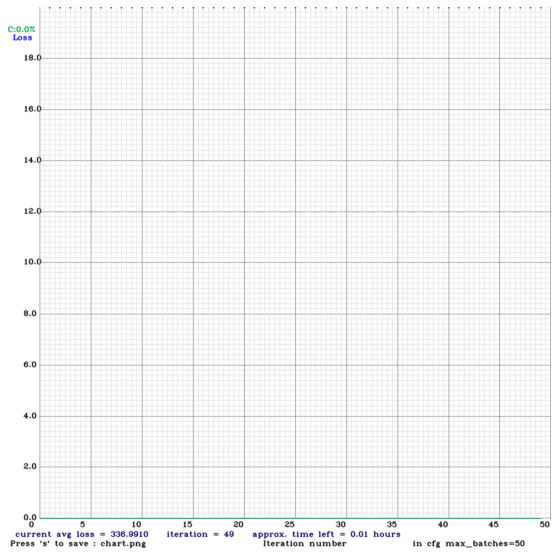

 calculation mAP (mean average precision)...
class_id = 0, name = blue, ap = 0.01%   	 (TP = 14, FP = 19733) 
class_id = 1, name = orange, ap = 0.00%   	 (TP = 0, FP = 21517) 
class_id = 2, name = yellow, ap = 0.02%   	 (TP = 7, FP = 14950) 
 for conf_thresh = 0.25, precision = 0.00, recall = 0.08, F1-score = 0.00 
 for conf_thresh = 0.25, TP = 21, FP = 56200, FN = 258, average IoU = 0.02 % 
 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.000113, or 0.01 % 
Using /content/darknet/cfg/yolov4-tiny-custom.cfg as source file 
subdivisions=16
mommentum=0.49000000000000027
decay=0.0007100000000000012
angle=30
saturation=5.599999999999996
hue=0
learning_rate=0.004699999999999999
max_batches=50
steps=40,45
filters=24
classes=3
filters=24
classes=3
Edit /content/darknet
Download pre-trained weights
https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
/content/darknet
./darknet detector train /co

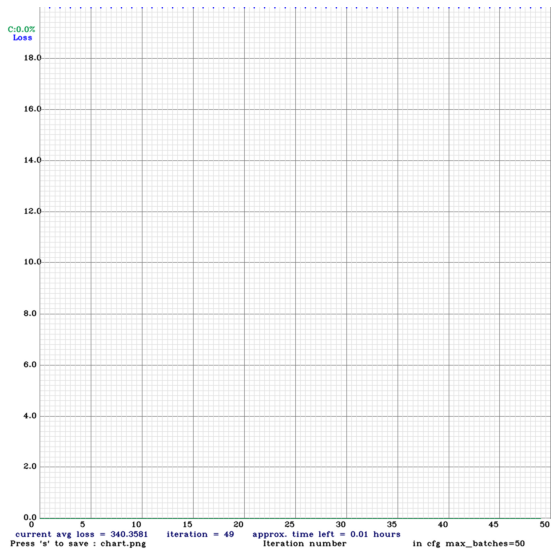

 calculation mAP (mean average precision)...
class_id = 0, name = blue, ap = 0.04%   	 (TP = 12, FP = 17595) 
class_id = 1, name = orange, ap = 0.00%   	 (TP = 0, FP = 21246) 
class_id = 2, name = yellow, ap = 0.01%   	 (TP = 9, FP = 19862) 
 for conf_thresh = 0.25, precision = 0.00, recall = 0.08, F1-score = 0.00 
 for conf_thresh = 0.25, TP = 21, FP = 58703, FN = 258, average IoU = 0.02 % 
 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.000187, or 0.02 % 


In [12]:
#Random Search of chosen yolov4.config file parameters
def getPList(startValue, endValue, incrementValue):
  pList = []
  currentValue = startValue
  for i in range(int((endValue-startValue)/incrementValue)):
    pList.append(currentValue)
    currentValue+=incrementValue
  return pList

from random import choice
#nOfModels decides how many times you run the random search
#The higher the value of this variable, the higher the chance of getting a good correlation is
nOfModels = 2
#resultsList = []

#[net] Section
widthList = getPList(8, 1024, 8)
heightList = getPList(8, 1024, 8)
#Data augmentation
angleList = getPList(0, 180, 5)
saturationList = getPList(0, 10, 0.1)
hueList = getPList(0, 1, 0.01)
blurList = getPList(0, 1, 0.01)
#Optimizer
momentumList = getPList(0.01, 1, 0.01)
decayList = getPList(0.00025, 0.00075, 0.00001)
learningList = getPList(0.0005, 0.015, 0.0001)

widthChosenList = []
heightChosenList = []
angleChosenList = []
saturationChosenList = []
hueChosenList = []
blurChosenList = []
momentumChosenList = []
decayChosenList = []
learningChosenList = []

for i in range(nOfModels):
  width = choice(widthList)
  widthChosenList.append(width)

  height = choice(heightList)
  heightChosenList.append(height)

  angle = choice(angleList)
  angleChosenList.append(angle)

  saturation = choice(saturationList)
  saturationChosenList.append(saturation)

  hue = choice(hueList)
  hueChosenList.append(hue)

  blur = choice(blurList)
  blurChosenList.append(blur)

  momentum = choice(momentumList)
  momentumChosenList.append(momentum)

  decay = choice(decayList)
  decayChosenList.append(decay)

  learning = choice(learningList)
  learningChosenList.append(learning)

  os = setParameters(width, height, angle, saturation, hue, blur, momentum, decay, learning, os)
  os = buildDarknet(os)
  downloadPTYoloWeights(os)
  imShow('chart.png')
  checkMAP()
  #f1Score = ...
  #currentOptions = [f"Combination number {i}", width, height, angle, saturation, hue, blur, momentum, decay, learning]
  #resultsList.append(currentOptions)

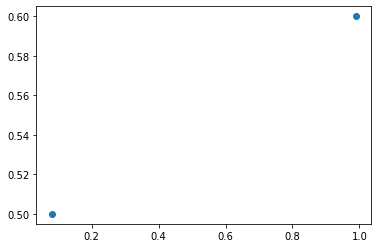

In [21]:
from matplotlib import pyplot as plt
f1s = [0.5, 0.6]
plt.scatter(hueChosenList, f1s)